## April Code pudding Project (Youtube Sentiment Analysis)

This project focuses on analyzing the relationship between YouTube comment sentiment and like-to-dislike ratios. The goal is to determine whether viewer sentiment expressed through comments aligns with engagement metrics provided by the platform. The analysis includes natural language processing techniques, exploratory data analysis, and supervised machine learning to classify comment sentiment as positive or negative.

A sentiment classification model will be trained and applied to a dataset of YouTube comments. The results will then be compared to like-to-dislike ratios to assess any discrepancies or patterns. Specific case studies will highlight instances where the comment sentiment diverges from the like/dislike ratio, providing insight into viewer behavior and platform dynamics.

This project is a collaborative effort, and the repository serves as the central space for development, data, and results.

### Importing and loading

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from wordcloud import WordCloud

import xgboost as xgb
from textblob import TextBlob

from tqdm import tqdm

In [46]:
dataset_path = os.path.join('..', 'datasets', 'archive')

comments = pd.read_csv(
    os.path.join(dataset_path, 'UScomments.csv'),
    on_bad_lines='skip',
    encoding='utf-8',
    low_memory=False
)
videos = pd.read_csv(
    os.path.join(dataset_path, 'USvideos.csv'), 
    on_bad_lines='skip', 
    encoding='utf-8')

In [47]:
comments.head()

,video_id,comment_text,likes,replies
0,XpVt6Z1Gjjo,Logan Paul it's yo big day ‼️‼️‼️,4,0
1,XpVt6Z1Gjjo,I've been following you from the start of your...,3,0
2,XpVt6Z1Gjjo,Say hi to Kong and maverick for me,3,0
3,XpVt6Z1Gjjo,MY FAN . attendance,3,0
4,XpVt6Z1Gjjo,trending 😉,3,0


In [48]:
videos.head(10)

,video_id,title,channel_title,category_id,tags,views,likes,dislikes,comment_total,thumbnail_link,date
0,XpVt6Z1Gjjo,1 YEAR OF VLOGGING -- HOW LOGAN PAUL CHANGED Y...,Logan Paul Vlogs,24,logan paul vlog|logan paul|logan|paul|olympics...,4394029,320053,5931,46245,https://i.ytimg.com/vi/XpVt6Z1Gjjo/default.jpg,13.09
1,K4wEI5zhHB0,iPhone X — Introducing iPhone X — Apple,Apple,28,Apple|iPhone 10|iPhone Ten|iPhone|Portrait Lig...,7860119,185853,26679,0,https://i.ytimg.com/vi/K4wEI5zhHB0/default.jpg,13.09
2,cLdxuaxaQwc,My Response,PewDiePie,22,[none],5845909,576597,39774,170708,https://i.ytimg.com/vi/cLdxuaxaQwc/default.jpg,13.09
3,WYYvHb03Eog,Apple iPhone X first look,The Verge,28,apple iphone x hands on|Apple iPhone X|iPhone ...,2642103,24975,4542,12829,https://i.ytimg.com/vi/WYYvHb03Eog/default.jpg,13.09
4,sjlHnJvXdQs,iPhone X (parody),jacksfilms,23,jacksfilms|parody|parodies|iphone|iphone x|iph...,1168130,96666,568,6666,https://i.ytimg.com/vi/sjlHnJvXdQs/default.jpg,13.09
5,cMKX2tE5Luk,The Disaster Artist | Official Trailer HD | A24,A24,1,a24|a24 films|a24 trailers|independent films|t...,1311445,34507,544,3040,https://i.ytimg.com/vi/cMKX2tE5Luk/default.jpg,13.09
6,8wNr-NQImFg,"The Check In: HUD, Ben Carson and Hurricanes",Late Night with Seth Meyers,23,Late night|Seth Meyers|check in|hud|Ben Carson...,666169,9985,297,1071,https://i.ytimg.com/vi/8wNr-NQImFg/default.jpg,13.09
7,_HTXMhKWqnA,iPhone X Impressions & Hands On!,Marques Brownlee,28,iPhone X|iphone x|iphone 10|iPhone X impressio...,1728614,74062,2180,15297,https://i.ytimg.com/vi/_HTXMhKWqnA/default.jpg,13.09
8,_ANP3HR1jsM,ATTACKED BY A POLICE DOG!!,RomanAtwoodVlogs,22,Roman Atwood|Roman|Atwood|roman atwood vlogs|f...,1338533,69687,678,5643,https://i.ytimg.com/vi/_ANP3HR1jsM/default.jpg,13.09
9,zgLtEob6X-Q,Honest Trailers - The Mummy (2017),Screen Junkies,1,screenjunkies|screen junkies|screenjunkies new...,1056891,29943,878,4046,https://i.ytimg.com/vi/zgLtEob6X-Q/default.jpg,13.09


### Comments

In [49]:
nltk.download('punkt')
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"[^a-z\s]", "", text)
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    return " ".join(tokens)

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/betaknight/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/betaknight/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


This function prepares text for analysis by cleaning and simplifying it. First, it downloads necessary language tools that help break text into words and remove common words that do not carry meaning. A list of common English words like "the", "is", and "and" is stored so they can be filtered out.

When the function is used on a comment:
1. The entire comment is changed to lowercase so that words like "Logan" and "logan" are treated the same.
2. Any links starting with "http" are removed from the comment.
3. All characters that are not letters or spaces are removed, including punctuation and numbers.
4. The remaining words are split into a list.
5. Each word is checked, and any word that is too common or not useful for analysis is removed.
6. The cleaned words are combined back into one string for further analysis.

In [50]:
comments['clean_text'] = comments['comment_text'].astype(str).apply(clean_text)
comments = comments.drop(columns=['comment_text'])

comments.head()

,video_id,likes,replies,clean_text
0,XpVt6Z1Gjjo,4,0,logan paul yo big day
1,XpVt6Z1Gjjo,3,0,ive following start vine channel seen vlogs
2,XpVt6Z1Gjjo,3,0,say hi kong maverick
3,XpVt6Z1Gjjo,3,0,fan attendance
4,XpVt6Z1Gjjo,3,0,trending


### Videos

In [51]:
videos['like_dislike_ratio'] = videos['likes'] / (videos['likes'] + videos['dislikes'])
videos = videos.drop(columns=['date'])

In [52]:
videos.head()

,video_id,title,channel_title,category_id,tags,views,likes,dislikes,comment_total,thumbnail_link,like_dislike_ratio
0,XpVt6Z1Gjjo,1 YEAR OF VLOGGING -- HOW LOGAN PAUL CHANGED Y...,Logan Paul Vlogs,24,logan paul vlog|logan paul|logan|paul|olympics...,4394029,320053,5931,46245,https://i.ytimg.com/vi/XpVt6Z1Gjjo/default.jpg,0.981806
1,K4wEI5zhHB0,iPhone X — Introducing iPhone X — Apple,Apple,28,Apple|iPhone 10|iPhone Ten|iPhone|Portrait Lig...,7860119,185853,26679,0,https://i.ytimg.com/vi/K4wEI5zhHB0/default.jpg,0.874471
2,cLdxuaxaQwc,My Response,PewDiePie,22,[none],5845909,576597,39774,170708,https://i.ytimg.com/vi/cLdxuaxaQwc/default.jpg,0.935471
3,WYYvHb03Eog,Apple iPhone X first look,The Verge,28,apple iphone x hands on|Apple iPhone X|iPhone ...,2642103,24975,4542,12829,https://i.ytimg.com/vi/WYYvHb03Eog/default.jpg,0.846123
4,sjlHnJvXdQs,iPhone X (parody),jacksfilms,23,jacksfilms|parody|parodies|iphone|iphone x|iph...,1168130,96666,568,6666,https://i.ytimg.com/vi/sjlHnJvXdQs/default.jpg,0.994158


## Creating Sentiment Feature

In [53]:
def get_sentiment(text):
    return TextBlob(text).sentiment.polarity

comments['sentiment_score'] = comments['clean_text'].apply(get_sentiment)
comments['sentiment_label'] = comments['sentiment_score'].apply(lambda x: 'positive' if x > 0 else 'negative')

In [54]:
sentiment_summary = comments.groupby('video_id')['sentiment_label'].value_counts().unstack().fillna(0)
sentiment_summary['comment_sentiment_ratio'] = sentiment_summary['positive'] / (sentiment_summary['positive'] + sentiment_summary['negative'])

In [55]:
cv_combined = videos.merge(sentiment_summary[['comment_sentiment_ratio']], on='video_id', how='inner')

In [43]:
cv_combined.head()

,video_id,title,channel_title,category_id,tags,views,likes,dislikes,comment_total,thumbnail_link,like_dislike_ratio,comment_sentiment_ratio
0,XpVt6Z1Gjjo,1 YEAR OF VLOGGING -- HOW LOGAN PAUL CHANGED Y...,Logan Paul Vlogs,24,logan paul vlog|logan paul|logan|paul|olympics...,4394029,320053,5931,46245,https://i.ytimg.com/vi/XpVt6Z1Gjjo/default.jpg,53.962738,0.288750
1,cLdxuaxaQwc,My Response,PewDiePie,22,[none],5845909,576597,39774,170708,https://i.ytimg.com/vi/cLdxuaxaQwc/default.jpg,14.496832,0.331665
2,WYYvHb03Eog,Apple iPhone X first look,The Verge,28,apple iphone x hands on|Apple iPhone X|iPhone ...,2642103,24975,4542,12829,https://i.ytimg.com/vi/WYYvHb03Eog/default.jpg,5.498679,0.331250
3,sjlHnJvXdQs,iPhone X (parody),jacksfilms,23,jacksfilms|parody|parodies|iphone|iphone x|iph...,1168130,96666,568,6666,https://i.ytimg.com/vi/sjlHnJvXdQs/default.jpg,170.186620,0.352500
4,cMKX2tE5Luk,The Disaster Artist | Official Trailer HD | A24,A24,1,a24|a24 films|a24 trailers|independent films|t...,1311445,34507,544,3040,https://i.ytimg.com/vi/cMKX2tE5Luk/default.jpg,63.431985,0.391429


TextBlob acts as the baseline or dummy model. It uses predefined word lists to estimate the sentiment of a comment without actually learning patterns from the data. While it can give a rough estimate of positive or negative tone, it does not adapt to the specific language, slang, or context used in YouTube comments. Because of this, it often misses sarcasm, informal expressions, or creative spelling.

By training a machine learning model on labeled data, a custom classifier can learn patterns that better reflect real viewer sentiment. This allows for more accurate predictions and a stronger foundation for comparing comment tone to engagement metrics.

### Analysis

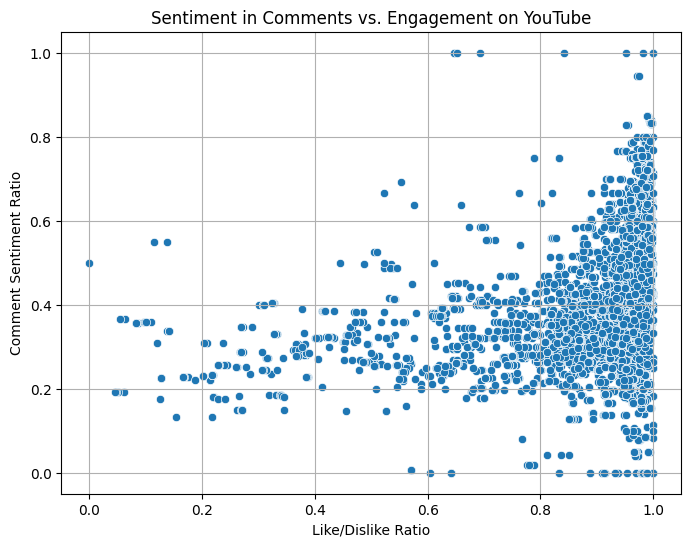

In [27]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=cv_combined, x='like_dislike_ratio', y='comment_sentiment_ratio')
plt.xlabel('Like/Dislike Ratio')
plt.ylabel('Comment Sentiment Ratio')
plt.title('Sentiment in Comments vs. Engagement on YouTube')
plt.grid(True)
plt.show()

This scatterplot compares two values for each video: the like-to-dislike ratio (along the bottom) and the ratio of positive comments to total comments (along the side). Each dot represents a video.

The cluster of points near the top right shows that many videos have a high number of likes and a decent number of positive comments. However, there is also a wide spread of comment sentiment for videos with a perfect like/dislike ratio. Some videos with no dislikes still have mostly negative comments, which suggests a possible disconnect between public engagement and the tone of viewer feedback.

The shape of the scatterplot supports the correlation score of around 0.28. There is a general upward trend, but many exceptions. This indicates that while videos with more likes tend to have more positive comments, this is not always true. Comment sentiment can vary widely even when a video is well-received in terms of likes.

In [28]:
cv_combined[['like_dislike_ratio', 'comment_sentiment_ratio']].corr()

,like_dislike_ratio,comment_sentiment_ratio
like_dislike_ratio,1.000000,0.278655
comment_sentiment_ratio,0.278655,1.000000


The correlation matrix shows how strongly the like-to-dislike ratio is related to the comment sentiment ratio. The value `1.000000` along the diagonal means each variable is perfectly correlated with itself. The off-diagonal value `0.278655` indicates the actual correlation between the two different ratios.

This correlation score is positive but relatively low, suggesting that there is a weak relationship between how people engage with a video through likes and dislikes and how they express their opinions through comments. In other words, a higher like/dislike ratio does not always mean that the comments will be more positive, and vice versa. This supports the idea that likes and comment tone can often reflect different aspects of viewer behavior.

In [31]:
cv_combined['ratio_diff'] = (cv_combined['like_dislike_ratio'] - cv_combined['comment_sentiment_ratio']).abs()
cv_combined.sort_values('ratio_diff', ascending=False).sample(5)

,video_id,title,channel_title,category_id,tags,views,likes,dislikes,comment_total,thumbnail_link,like_dislike_ratio,comment_sentiment_ratio,ratio_diff
1611,-zCYX0esYlo,Everything You Need to Know About The Last Dab...,First We Feast,26,First we feast|fwf|firstwefeast|food|food porn...,662805,18403,214,2205,https://i.ytimg.com/vi/-zCYX0esYlo/default.jpg,0.988505,0.383333,0.605172
307,IMG0u0_cKNc,Here's what happens when two hurricanes collide,Tech Insider,28,Tech Insider|TI|Tech|Science|Innovation|Digita...,151736,2153,102,444,https://i.ytimg.com/vi/IMG0u0_cKNc/default.jpg,0.954767,0.265000,0.689767
2768,ILDy6kYU-xQ,Are you a body with a mind or a mind with a bo...,TED-Ed,27,TED|TED-Ed|TED Education|TED Ed|Maryam Alimard...,321735,14367,322,1679,https://i.ytimg.com/vi/ILDy6kYU-xQ/default.jpg,0.978079,0.315000,0.663079
2548,TNhyrPaGFYQ,FIX YOUR LIFE (YIAY #359),jacksfilms,23,jacksfilms|yiay|fix|your|life|lives|live|advice,1595329,76458,1718,52400,https://i.ytimg.com/vi/TNhyrPaGFYQ/default.jpg,0.978024,0.155000,0.823024
7619,CAQ2wWVlOuc,Jeff Bezos smashes bottle of champagne while p...,Tech Insider,28,Tech Insider|TI|Tech|Science|Innovation|Digita...,66230,661,153,203,https://i.ytimg.com/vi/CAQ2wWVlOuc/default.jpg,0.812039,0.288194,0.523845


These rows show videos where the like-to-dislike ratio is perfect (1.0), but the comment sentiment ratio is completely negative (0.0). This creates the largest possible gap between positive public engagement and negative comment tone, which is measured in the column `ratio_diff`.

- `like_dislike_ratio = 1.0` means the video has only likes and no dislikes.
- `comment_sentiment_ratio = 0.0` means that all the comments analyzed were negative.
- `ratio_diff = 1.0` shows the absolute difference between the like/dislike ratio and the comment sentiment ratio.

In each of these examples, there is a contradiction between how viewers interact with the video through likes and how they express themselves through comments. These cases are useful for closer analysis because they may reveal sarcasm, controversial content, or limitations in how sentiment was detected.